# Создание AI-агента на базе LLM

## Получение доступа к модели DeepSeek по API OpenRouter

In [ ]:
!pip install langgraph langchain langchain-openai langchain_community

In [4]:
## токен для доступа к моделям https://openrouter.ai/
OPENROUTER_TOKEN = "PASTE_YOUR_TOKEN_HERE"

In [5]:
from langchain_openai import ChatOpenAI

deepseek_llm = ChatOpenAI(
    api_key=OPENROUTER_TOKEN,
    base_url="https://openrouter.ai/api/v1",
    model="deepseek/deepseek-chat-v3.1"
)

deepseek_response = deepseek_llm.invoke("Привет! Как твои дела?").content
print(deepseek_response)

Привет! Спасибо, что спросил(а) 😊 У меня всё отлично — я работаю, генерирую текст, ищу информацию и помогаю пользователям. Расскажи, как твои дела? Чем могу помочь?


## Организация памяти LLM и красивое оформление диалога

In [6]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

question = "Сколько лап у паука?"
additional_question = "А зубов?"

question_message = HumanMessage(content=question)
additional_question_message = HumanMessage(content=additional_question)

dialogue = []
dialogue.append(question_message)

# answer1_message
dialogue.append(AIMessage(content=deepseek_llm.invoke(dialogue).content)) # .invoke([question_message])
dialogue.append(additional_question_message)

# answer2_message
dialogue.append(AIMessage(content=deepseek_llm.invoke(dialogue).content)) # не просто .invoke([additional_question_message])

for phrase in dialogue:
    phrase.pretty_print()

================================ Human Message =================================

Сколько лап у паука?
================================== Ai Message ==================================

Конечно!

У паука **8 лап**.

И немного подробнее, чтобы избежать путаницы:

*   **8 лап (ходячих ног)**: Это правильный ответ. У всех пауков 4 пары ходильных ног.
*   **Не путать с педипальпами**: Педипальпы - это дополнительные конечности возле рта. Они больше похожи на короткие щупальца и используются для удержания добычи, а у самцов - для спаривания. Это **не лапы**.
*   **А почему не 6, как у насекомых?**: Потому что пауки - не насекомые. Они относятся к другому классу - **паукообразные** (арахниды). У всех арахнидов (пауков, скорпионов, клещей) по 4 пары ходильных ног.

**Итого: у паука восемь лап.**
================================ Human Message =================================

А зубов?
================================== Ai Message ==================================

Отличный вопрос! С зубами у 

## Создание агента при помощи фреймворка LangGraph

Задача агента - говорить, над какой страной или над каким материком находится сейчас телескоп Хаббл.


Он будет работать в 3 шага:
1. Понимать, что нужно: страна или материк
2. Получать текущие координаты Хаббла
3. Говорить, над чем находится Хаббл

<div align="center">
  <img src="figures/hubble.png" alt="Телескоп" width="450" height="350">
</div>

LangGraph позволит реализовывать AI-агентов в виде графа из различных состояний.

<div align="center">
  <img src="figures/graph.png" alt="Граф" width="450" height="350">
</div>

Зададим архитектуру кратковременной памяти/state, через которую будем передавать данные между шагами.

In [8]:
from typing import TypedDict, List
from langgraph.graph import START, END, StateGraph

class Coordinates(TypedDict):
    lat: float
    long: float

# Define a complete State class with all fields
class HubbleState(TypedDict):
    question: str
    question_kind: int
    coordinates: Coordinates
    latitude: float
    longitude: float
    answer: str

Определение типа вопроса (страна или океан/материк) с помощью LLM

In [9]:
def get_question_type(state: HubbleState):
    prompt = f"""
# Инструкция
Перед тобой вопрос пользователя к агенту. Тебе нужно классифицировать вопрос на два класса (дополнительный класс 0 - некорректный запрос).
Если вопрос касается страны, над которой находится Hubble - верни 1,
если касается материка или океана - верни 2,
если прочего - верни 0.
Напиши только одно число, не пиши никаких коментариев. Не размышляй
# Примеры
Пример 1
Вопрос: Над какой страной пролетает Hubble?
Ответ: 1
------
Пример 2
Вопрос: Над каким океаном пролетает Hubble?
Ответ: 2
------
Пример 3
Вопрос: Сколько космонавтов на Hubble?
Ответ: 0
------
# Вопрос пользователя, который нужно классифицировать
{state['question']}
    """

    result = deepseek_llm.invoke(prompt).content

    print("get_question_type result:", result)
    try:
        question_kind = int(result)
    except:
        question_kind = 0

    print("State after get_question_type:", {"question": state.get('question'), "question_kind": question_kind})
    return {"question_kind": question_kind}

Получение координат Хаббла по API

In [10]:
import requests

def get_hubble_location(state: HubbleState):
    """
    Получает текущие координаты космического телескопа Hubble (NORAD ID 20580)
    через API N2YO и сохраняет их в state["coordinates"].

    Параметры:
        state (dict): текущее состояние агента
        api_key (str): API ключ для https://www.n2yo.com/api/

    Возвращает:
        dict: обновлённое состояние с координатами
    """
    print("State entering get_hubble_location:", state)

    # NORAD ID телескопа Hubble
    hubble_id = 20580

    # Позиция наблюдателя не влияет на результат
    observer_lat, observer_lng, observer_alt = 0, 0, 0

    # Формирование запроса
    url = (
        f"https://api.n2yo.com/rest/v1/satellite/positions/"
        f"{hubble_id}/{observer_lat}/{observer_lng}/{observer_alt}/1/&apiKey=PASTE_YOUR_TOKEN_HERE"
    )

    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    # Проверка и извлечение координат
    if "positions" not in data or not data["positions"]:
        raise ValueError("Не удалось получить данные о координатах Hubble.")

    position = data["positions"][0]
    latitude = position["satlatitude"]
    longitude = position["satlongitude"]

    print("Hubble coordinates:", latitude, longitude)

    # Обновляем состояние
    state["coordinates"] = {"lat": latitude, "long": longitude}
    return state

Получение требуемого ответа по координатам

In [11]:
def get_answer(state: HubbleState):
    print("Full state entering get_answer:", state)

    # Check if coordinates are in the state
    if "coordinates" not in state:
        print("ERROR: Missing coordinates in state")
        return {"answer": "Ошибка: Не удалось получить координаты Hubble"}

    lat = state["coordinates"]["lat"]
    long = state["coordinates"]["long"]

    if state["question_kind"] == 1:
        prompt = f"Над какой страной пролетает Hubble, если я запросила координаты, над которыми она находится, и они равны: ({lat},{long})?"
    elif state["question_kind"] == 2:
        prompt = f"Над каким материком или океаном пролетает Hubble, если я запросила координаты, над которыми она находится, и они равны: ({lat},{long})?"
    else:
        prompt = f"Напиши в ответе: ОШИБКА, ЗАДАЙТЕ КОРРЕКТНЫЙ ЗАПРОС"

    result = deepseek_llm.invoke(prompt).content
    print("get_answer result:", result)
    return {"answer": result}

Соберем весь граф размышлений.

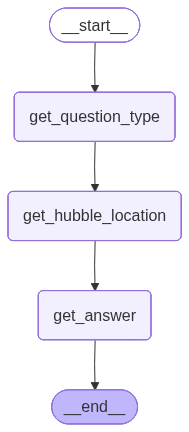

In [12]:
graph_builder = StateGraph(HubbleState)

# сначала создадим вершины
graph_builder.add_node("get_question_type", get_question_type)
graph_builder.add_node("get_hubble_location", get_hubble_location)
graph_builder.add_node("get_answer", get_answer)

# потом соединим их ребрами
graph_builder.add_edge(START, "get_question_type")
graph_builder.add_edge("get_question_type", "get_hubble_location")
graph_builder.add_edge("get_hubble_location", "get_answer")
graph_builder.add_edge("get_answer", END)

graph = graph_builder.compile()
graph

На вход агенту нужно подавать State или его кусочек.

In [13]:
answer1 = graph.invoke({"question": "Над какой страной пролетает Hubble?"})["answer"]
print('---------------')
print(answer1)

get_question_type result: 1
State after get_question_type: {'question': 'Над какой страной пролетает Hubble?', 'question_kind': 1}
State entering get_hubble_location: {'question': 'Над какой страной пролетает Hubble?', 'question_kind': 1}
Hubble coordinates: -25.17553625 148.78672823
Full state entering get_answer: {'question': 'Над какой страной пролетает Hubble?', 'question_kind': 1, 'coordinates': {'lat': -25.17553625, 'long': 148.78672823}}
get_answer result: Отличный вопрос! Координаты, которые вы предоставили, указывают на точку на поверхности Земли. Давайте разберем, что они значат и над какой территорией в данный момент пролетал Hubble.

**Краткий ответ:**
Hubble пролетал над **восточной частью Австралии**, в штате **Квинсленд**.

**Подробное объяснение:**

1.  **Чтение координат:**
    *   **-25.17553625** — это **широта**. Отрицательное значение означает, что это южная широта.
    *   **148.78672823** — это **долгота**. Положительное значение означает, что это восточная долго

In [14]:
answer2 = graph.invoke({"question": "Над каким океаном пролетает Hubble?"})["answer"]
print('---------------')
print(answer2)

get_question_type result: 2
State after get_question_type: {'question': 'Над каким океаном пролетает Hubble?', 'question_kind': 2}
State entering get_hubble_location: {'question': 'Над каким океаном пролетает Hubble?', 'question_kind': 2}
Hubble coordinates: -24.29644156 152.21762171
Full state entering get_answer: {'question': 'Над каким океаном пролетает Hubble?', 'question_kind': 2, 'coordinates': {'lat': -24.29644156, 'long': 152.21762171}}
get_answer result: Отличный вопрос! Давайте разберемся.

Координаты, которые вы предоставили (-24.29644156, 152.21762171), показывают точку на поверхности Земли, над которой в данный момент пролетает телескоп Hubble.

**Расшифровка координат:**
*   **-24.29644156** — это **широта** (отрицательное значение означает южную широту).
*   **152.21762171** — это **долгота** (положительное значение означает восточную долготу).

Теперь найдем это место на карте:
*   **Широта ~24.3° ю.ш.**: Это район к югу от тропика Козерога.
*   **Долгота ~152.2° в.д.**

In [15]:
answer3 = graph.invoke({"question": "Над какой страной пролетает Хаббл и cколько космонавтов на Hubble?"})["answer"]
print('---------------')
print(answer3)

get_question_type result: 0
State after get_question_type: {'question': 'Над какой страной пролетает Хаббл и cколько космонавтов на Hubble?', 'question_kind': 0}
State entering get_hubble_location: {'question': 'Над какой страной пролетает Хаббл и cколько космонавтов на Hubble?', 'question_kind': 0}
Hubble coordinates: -23.78826437 154.03873438
Full state entering get_answer: {'question': 'Над какой страной пролетает Хаббл и cколько космонавтов на Hubble?', 'question_kind': 0, 'coordinates': {'lat': -23.78826437, 'long': 154.03873438}}
get_answer result: ОШИБКА, ЗАДАЙТЕ КОРРЕКТНЫЙ ЗАПРОС
---------------
ОШИБКА, ЗАДАЙТЕ КОРРЕКТНЫЙ ЗАПРОС
